In [102]:
import pandas as pd
import numpy as np

import re
import os

from chord import Chord

import urllib.request
from bs4 import BeautifulSoup

import networkx as nx

In [19]:
fn_list = os.listdir('data/processed/corrected/')

In [20]:
fn_list

['CheerUp_romanized_line_dist.csv',
 'CryForMe_romanized_line_dist.csv',
 'DanceTheNightAway_romanized_line_dist.csv',
 'Fancy_romanized_line_dist.csv',
 'FeelSpecial_romanized_line_dist.csv',
 'HeartShaker_romanized_line_dist.csv',
 'ICantStopMe_romanized_line_dist.csv',
 'KnockKnock_romanized_line_dist.csv',
 'LikeOohAhh_romanized_line_dist.csv',
 'Likey_romanized_line_dist.csv',
 'More&More_romanized_line_dist.csv',
 'Signal_romanized_line_dist.csv',
 'TT_romanized_line_dist.csv',
 'WhatIsLove_romanized_line_dist.csv',
 'YesOrYes_romanized_line_dist.csv']

In [21]:
song_names = ["CheerUp","CryForMe","DanceTheNightAway","Fancy","FeelSpecial","ICantStopMe","HeartShaker","KnockKnock",\
              "LikeOohAhh","Likey","More&More","Signal","TT","WhatIsLove","YesOrYes",]

In [22]:
from itertools import tee

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return list(zip(a, b))

In [83]:
edge_dfs = []
for n,fn in enumerate(fn_list):
    print(fn)
    print(song_names[n])
    df = pd.read_csv('data/processed/corrected/'+fn)
    #df = pd.read_csv('data/processed/corrected/'+fn)
    df.columns = [c.lower() for c in df.columns]
    #filter out ALL
    df=df[df['vocal1']!="ALL"]
    #recompute duration
    df['duration'] = pd.to_datetime(df['end_time'])-pd.to_datetime(df['start_time']) 
    df['duration'] = df['duration']/ np.timedelta64(1, 's')
    vocal_order = df['vocal1'].loc[df['vocal1'].shift() != df['vocal1']].values
    
    print([(n,c) for c in enumerate(df['vocal1'].values) if c=='Mina '])
    
    vocal_pair_order = pairwise(vocal_order)
    edge_df = pd.DataFrame(vocal_pair_order, columns=['from_member','to_member'])
    edge_df['song_name']=song_names[n]
    edge_dfs.append(edge_df)
    
all_edge_df = pd.concat(edge_dfs)
all_edge_df.head()

CheerUp_romanized_line_dist.csv
CheerUp
[]
CryForMe_romanized_line_dist.csv
CryForMe
[]
DanceTheNightAway_romanized_line_dist.csv
DanceTheNightAway
[]
Fancy_romanized_line_dist.csv
Fancy
[]
FeelSpecial_romanized_line_dist.csv
FeelSpecial
[]
HeartShaker_romanized_line_dist.csv
ICantStopMe
[]
ICantStopMe_romanized_line_dist.csv
HeartShaker
[]
KnockKnock_romanized_line_dist.csv
KnockKnock
[]
LikeOohAhh_romanized_line_dist.csv
LikeOohAhh
[]
Likey_romanized_line_dist.csv
Likey
[]
More&More_romanized_line_dist.csv
More&More
[]
Signal_romanized_line_dist.csv
Signal
[]
TT_romanized_line_dist.csv
TT
[]
WhatIsLove_romanized_line_dist.csv
WhatIsLove
[]
YesOrYes_romanized_line_dist.csv
YesOrYes
[]


,from_member,to_member,song_name
0,Nayeon,Mina,CheerUp
1,Mina,Sana,CheerUp
2,Sana,Mina,CheerUp
3,Mina,Tzuyu,CheerUp
4,Tzuyu,Sana,CheerUp


## Chord Diagram

In [132]:
members_ordered = ['Nayeon','Jeongyeon','Momo',\
                   'Sana','Jihyo','Mina',\
                'Dahyun', 'Chaeyoung','Tzuyu']

In [135]:
chord_data_df = all_edge_df.groupby(['from_member','to_member']).count().reset_index()
#convert to category to preserve order
chord_data_df['from_member'] = chord_data_df['from_member'].astype(pd.api.types.CategoricalDtype(categories=members_ordered))
chord_data_df['to_member'] = chord_data_df['to_member'].astype(pd.api.types.CategoricalDtype(categories=members_ordered))

chord_data_df = chord_data_df.rename(columns = {"song_name":"num_occurences"}).sort_values('num_occurences', ascending=False)
chord_data_df

,from_member,to_member,num_occurences
8,Dahyun,Chaeyoung,23
29,Jihyo,Nayeon,20
51,Nayeon,Jihyo,19
0,Chaeyoung,Dahyun,18
10,Dahyun,Jihyo,16
...,...,...,...
14,Dahyun,Sana,2
40,Momo,Chaeyoung,2
13,Dahyun,Nayeon,2
58,Sana,Jeongyeon,1


In [163]:
chord_data_df['pair_set'] = chord_data_df.apply(lambda x: {x['from_member'],x['to_member']}, axis=1)
chord_data_df['pair'] = chord_data_df['pair_set'].apply(lambda x: "-".join(list(x)))

data_df =chord_data_df.groupby('pair')[['num_occurences']].sum().reset_index()
data_df['from_member']=data_df['pair'].apply(lambda x: x.split("-")[0])
data_df['to_member']=data_df['pair'].apply(lambda x: x.split("-")[1])
data_df

,pair,num_occurences,from_member,to_member
0,Chaeyoung-Dahyun,41,Chaeyoung,Dahyun
1,Chaeyoung-Jeongyeon,8,Chaeyoung,Jeongyeon
2,Chaeyoung-Jihyo,5,Chaeyoung,Jihyo
3,Chaeyoung-Mina,8,Chaeyoung,Mina
4,Chaeyoung-Momo,5,Chaeyoung,Momo
5,Chaeyoung-Nayeon,16,Chaeyoung,Nayeon
6,Chaeyoung-Tzuyu,8,Chaeyoung,Tzuyu
7,Dahyun-Jeongyeon,8,Dahyun,Jeongyeon
8,Dahyun-Momo,14,Dahyun,Momo
9,Dahyun-Nayeon,10,Dahyun,Nayeon


In [164]:
data = np.zeros((len(members_ordered),len(members_ordered)))

# populate the matrix
# nested for loop to go over each characcter combination
for j,n in enumerate(members_ordered):
    for i,m in enumerate(members_ordered):
        print((m,n))
        try:
            #BUG FIX: match array location by considering both possible orders of speaker pairs 
            val = data_df[(data_df['from_member']==m)&(data_df['to_member']==n)|
                       (data_df['from_member']==n)&(data_df['to_member']==m)]['num_occurences'].values[0]
            data[j][i] = val
            
        except:
            print("No pair data for characters %s and %s" % (m,n))
            data[j][i] = 0
            
# is it okay to trigger exception for differently ordered pairs?
data

('Nayeon', 'Nayeon')
No pair data for characters Nayeon and Nayeon
('Jeongyeon', 'Nayeon')
('Momo', 'Nayeon')
('Sana', 'Nayeon')
('Jihyo', 'Nayeon')
('Mina', 'Nayeon')
('Dahyun', 'Nayeon')
('Chaeyoung', 'Nayeon')
('Tzuyu', 'Nayeon')
('Nayeon', 'Jeongyeon')
('Jeongyeon', 'Jeongyeon')
No pair data for characters Jeongyeon and Jeongyeon
('Momo', 'Jeongyeon')
('Sana', 'Jeongyeon')
('Jihyo', 'Jeongyeon')
('Mina', 'Jeongyeon')
('Dahyun', 'Jeongyeon')
('Chaeyoung', 'Jeongyeon')
('Tzuyu', 'Jeongyeon')
('Nayeon', 'Momo')
('Jeongyeon', 'Momo')
('Momo', 'Momo')
No pair data for characters Momo and Momo
('Sana', 'Momo')
('Jihyo', 'Momo')
('Mina', 'Momo')
('Dahyun', 'Momo')
('Chaeyoung', 'Momo')
('Tzuyu', 'Momo')
('Nayeon', 'Sana')
('Jeongyeon', 'Sana')
('Momo', 'Sana')
('Sana', 'Sana')
No pair data for characters Sana and Sana
('Jihyo', 'Sana')
('Mina', 'Sana')
('Dahyun', 'Sana')
('Chaeyoung', 'Sana')
('Tzuyu', 'Sana')
('Nayeon', 'Jihyo')
('Jeongyeon', 'Jihyo')
('Momo', 'Jihyo')
('Sana', 'Jihyo')


array([[ 0.,  9.,  8.,  9., 39., 20., 10., 16., 13.],
       [ 9.,  0., 11.,  2., 25.,  7.,  8.,  8.,  5.],
       [ 8., 11.,  0., 11., 10., 20., 14.,  5., 12.],
       [ 9.,  2., 11.,  0.,  8., 16.,  8., 12., 25.],
       [39., 25., 10.,  8.,  0., 14., 23.,  5., 13.],
       [20.,  7., 20., 16., 14.,  0.,  8.,  8., 21.],
       [10.,  8., 14.,  8., 23.,  8.,  0., 41.,  5.],
       [16.,  8.,  5., 12.,  5.,  8., 41.,  0.,  8.],
       [13.,  5., 12., 25., 13., 21.,  5.,  8.,  0.]])

In [148]:
chord_data_df[chord_data_df['from_member']=="Jihyo"]

,from_member,to_member,num_occurences
29,Jihyo,Nayeon,20
26,Jihyo,Jeongyeon,14
31,Jihyo,Tzuyu,7
24,Jihyo,Chaeyoung,7
25,Jihyo,Dahyun,7
27,Jihyo,Mina,6
28,Jihyo,Momo,6
30,Jihyo,Sana,4


In [150]:
chord_data_df[chord_data_df['from_member']=="Nayeon"]

,from_member,to_member,num_occurences
51,Nayeon,Jihyo,19
52,Nayeon,Mina,10
50,Nayeon,Jeongyeon,9
53,Nayeon,Momo,8
49,Nayeon,Dahyun,8
55,Nayeon,Tzuyu,7
54,Nayeon,Sana,6
48,Nayeon,Chaeyoung,4


In [145]:
chord_data_matrix_df = pd.pivot(chord_data_df, index="from_member", columns='to_member', values='num_occurences')
chord_data_matrix_df
# Converting the DataFrame to a 2D List, as it is the required input format.
chord_data_matrix = chord_data_matrix_df.fillna(0).to_numpy().tolist()
chord_data_matrix

[[0.0, 9.0, 8.0, 6.0, 19.0, 10.0, 8.0, 4.0, 7.0],
 [5.0, 0.0, 6.0, 1.0, 11.0, 4.0, 6.0, 5.0, 5.0],
 [10.0, 11.0, 0.0, 5.0, 4.0, 9.0, 7.0, 2.0, 5.0],
 [3.0, 1.0, 6.0, 0.0, 4.0, 7.0, 6.0, 5.0, 14.0],
 [20.0, 14.0, 6.0, 4.0, 0.0, 6.0, 7.0, 7.0, 7.0],
 [10.0, 3.0, 11.0, 9.0, 8.0, 0.0, 4.0, 5.0, 8.0],
 [2.0, 2.0, 7.0, 2.0, 16.0, 4.0, 0.0, 23.0, 6.0],
 [12.0, 3.0, 3.0, 7.0, 5.0, 3.0, 18.0, 0.0, 3.0],
 [6.0, 0.0, 7.0, 11.0, 6.0, 13.0, 5.0, 5.0, 0.0]]

In [138]:
members = chord_data_matrix_df.index.values.tolist()
members

['Nayeon',
 'Jeongyeon',
 'Momo',
 'Sana',
 'Jihyo',
 'Mina',
 'Dahyun',
 'Chaeyoung',
 'Tzuyu']

In [139]:
find_member_colors = {'#00ccff': 'Nayeon', '#84cc00': 'Jeongyeon', '#ffb1b8': 'Momo', '#996de7': 'Sana', '#ffb74d': 'Jihyo', '#1af0af': 'Mina', '#ffe7ff': 'Dahyun', '#ff1744': 'Chaeyoung', '#396ad8': 'Tzuyu'}
find_member_colors = {y:x for x,y in find_member_colors.items()}
find_member_colors

{'Nayeon': '#00ccff',
 'Jeongyeon': '#84cc00',
 'Momo': '#ffb1b8',
 'Sana': '#996de7',
 'Jihyo': '#ffb74d',
 'Mina': '#1af0af',
 'Dahyun': '#ffe7ff',
 'Chaeyoung': '#ff1744',
 'Tzuyu': '#396ad8'}

In [140]:
member_colors = [find_member_colors[m] for m in members]
member_colors

['#00ccff',
 '#84cc00',
 '#ffb1b8',
 '#996de7',
 '#ffb74d',
 '#1af0af',
 '#ffe7ff',
 '#ff1744',
 '#396ad8']

In [144]:
Chord(chord_data_matrix, members,\
      colors=member_colors).to_html('twice_diagram.html')

In [142]:
Chord?

## Network Analysis

In [93]:
network_data_df = all_edge_df.groupby(['from_member','to_member']).count().reset_index()
network_data_df = network_data_df.rename(columns = {"song_name":"num_occurences"})
network_data_df

,from_member,to_member,num_occurences
0,Chaeyoung,Dahyun,18
1,Chaeyoung,Jeongyeon,3
2,Chaeyoung,Jihyo,5
3,Chaeyoung,Mina,3
4,Chaeyoung,Momo,3
...,...,...,...
66,Tzuyu,Jihyo,6
67,Tzuyu,Mina,13
68,Tzuyu,Momo,7
69,Tzuyu,Nayeon,6


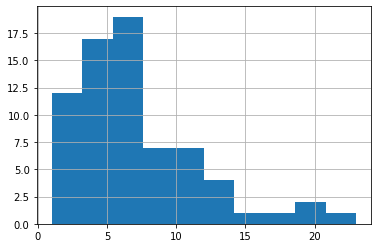

In [94]:
network_data_df['num_occurences'].hist()

In [95]:
network_data_df['num_occurences'].describe()

count    71.000000
mean      7.197183
std       4.496410
min       1.000000
25%       4.000000
50%       6.000000
75%       9.000000
max      23.000000
Name: num_occurences, dtype: float64

In [96]:
network_data_df = network_data_df[network_data_df['num_occurences']>=8].sort_values('num_occurences', ascending=False)
network_data_df

,from_member,to_member,num_occurences
8,Dahyun,Chaeyoung,23
29,Jihyo,Nayeon,20
51,Nayeon,Jihyo,19
0,Chaeyoung,Dahyun,18
10,Dahyun,Jihyo,16
26,Jihyo,Jeongyeon,14
63,Sana,Tzuyu,14
67,Tzuyu,Mina,13
5,Chaeyoung,Nayeon,12
42,Momo,Jeongyeon,11


In [97]:
#build network from edgelist
G = nx.from_pandas_edgelist(network_data_df, source='from_member', target='to_member',edge_attr='num_occurences',
                            create_using = nx.DiGraph())

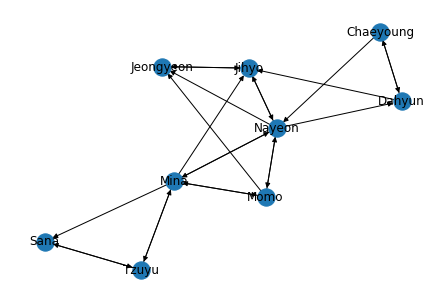

In [98]:
nx.draw_kamada_kawai(G,with_labels = True)

In [99]:
for n in G.nodes():
    print(n)

Dahyun
Chaeyoung
Jihyo
Nayeon
Jeongyeon
Sana
Tzuyu
Mina
Momo


In [100]:
from networkx.algorithms import community

community_lookup =[list(x) for x in community.greedy_modularity_communities(G.to_undirected())]
for member in G.nodes():
    G.nodes[member]['color']=["C"+str(n) for n,x in enumerate(community_lookup) if member in x][0]


{'Dahyun': Text(0.7992108421384284, 0.38908997887277474, 'Dahyun'),
 'Chaeyoung': Text(0.684251964358647, 0.8711719219827552, 'Chaeyoung'),
 'Jihyo': Text(-0.015067382194721604, 0.6188943034898648, 'Jihyo'),
 'Nayeon': Text(0.1344374078637813, 0.20167733865370885, 'Nayeon'),
 'Jeongyeon': Text(-0.47529789258608657, 0.6293891587212963, 'Jeongyeon'),
 'Sana': Text(-1.0999999999999999, -0.7857514684880226, 'Sana'),
 'Tzuyu': Text(-0.5894194992020055, -0.9820741511266424, 'Tzuyu'),
 'Mina': Text(-0.4129426843394053, -0.3682315976863365, 'Mina'),
 'Momo': Text(0.07482724396136234, -0.47416548441939854, 'Momo')}

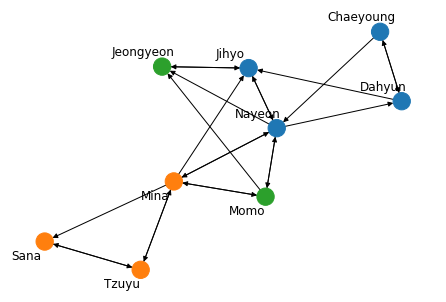

In [101]:
#plot network
pos = nx.kamada_kawai_layout(G)
pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0]-0.1, v[1]+0.1)
    else:
        pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        
labels = {n:n for n in G.nodes()}
colors = [n[1]['color'] for n in G.nodes(data=True)]

nx.draw_kamada_kawai(G,node_color=colors)
nx.draw_networkx_labels(G, pos_higher, labels)

In [47]:
fn = "More&More_romanized_line_dist.csv"
df = pd.read_csv('data/processed/corrected/'+fn)
df.columns = [c.lower() for c in df.columns]

In [49]:
df[df['vocal1'].str.contains('Mina  ')]['vocal1'].values

array([], dtype=object)

In [65]:
df=df[df['vocal1']!="ALL"]

In [66]:
df['duration'] = pd.to_datetime(df['end_time'])-pd.to_datetime(df['start_time']) 
df['duration'] = df['duration']/ np.timedelta64(1, 's')
df

,start_time,end_time,lyric,vocal1,vocal2,duration
0,"00:00:13,700","00:00:18,900",geureon nari isseo,Chaeyoung,NaN,5.20
1,"00:00:18,900","00:00:23,600",gapjagi honjain geonman gateun nal eodil gado ...,Chaeyoung,NaN,4.70
2,"00:00:23,600","00:00:28,000",gogaen tteolgweojineun nal,Chaeyoung,NaN,4.40
3,"00:00:28,000","00:00:33,000",geureol ttaemada naege eolmana naega sojunghanji,Tzuyu,NaN,5.00
4,"00:00:33,000","00:00:37,500",malhaejuneun neoye geu hanmadie,Tzuyu,NaN,4.50
5,"00:00:37,800","00:00:39,500",Everything’s alright,Momo,NaN,1.70
6,"00:00:39,500","00:00:42,800",chorahan Nobodyeseo dashi Somebody,Momo,NaN,3.30
7,"00:00:42,800","00:00:44,900",teukbyeolhan naro byeonhae,Momo,NaN,2.10
8,"00:00:45,000","00:00:47,900",You make me feel special,Sana,NaN,2.90
9,"00:00:48,000","00:00:51,800",sesangi amuri nal jujeoanchyeodo,Sana,NaN,3.80


In [67]:
vocal_order = df['vocal1'].loc[df['vocal1'].shift() != df['vocal1']].values
vocal_pair_order = pairwise(vocal_order)

In [68]:
edge_df = pd.DataFrame(vocal_pair_order, columns=['from_member','to_member'])
edge_df

,from_member,to_member
0,Chaeyoung,Tzuyu
1,Tzuyu,Momo
2,Momo,Sana
3,Sana,Nayeon
4,Nayeon,Mina
5,Mina,Momo
6,Momo,Tzuyu
7,Tzuyu,Jihyo
8,Jihyo,Jeongyeon
9,Jeongyeon,Dahyun


In [69]:
#build network from edgelist
G = nx.from_pandas_edgelist(edge_df, source='from_member', target='to_member', create_using = nx.DiGraph())


In [70]:
#degree
metrics_df = pd.DataFrame(G.degree(), columns=['member','degree'])
metrics_df

,member,degree
0,Chaeyoung,1
1,Tzuyu,4
2,Momo,4
3,Sana,2
4,Nayeon,3
5,Mina,2
6,Jihyo,4
7,Jeongyeon,2
8,Dahyun,2


In [71]:
bc_df = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['member','betweenness_c'])
metrics_df = metrics_df.merge(bc_df, on='member', how='left')
metrics_df

,member,degree,betweenness_c
0,Chaeyoung,1,0.000000
1,Tzuyu,4,0.339286
2,Momo,4,0.410714
3,Sana,2,0.053571
4,Nayeon,3,0.375000
5,Mina,2,0.357143
6,Jihyo,4,0.482143
7,Jeongyeon,2,0.125000
8,Dahyun,2,0.107143


In [72]:
eig_df = pd.DataFrame(nx.eigenvector_centrality(G).items()  , columns=['member','eigenvector_c'])
metrics_df = metrics_df.merge(eig_df, on='member', how='left')
metrics_df

,member,degree,betweenness_c,eigenvector_c
0,Chaeyoung,1,0.000000,1.100863e-14
1,Tzuyu,4,0.339286,3.293915e-01
2,Momo,4,0.410714,4.687518e-01
3,Sana,2,0.053571,3.293915e-01
4,Nayeon,3,0.375000,4.805454e-01
5,Mina,2,0.357143,3.376806e-01
6,Jihyo,4,0.482143,3.544618e-01
7,Jeongyeon,2,0.125000,2.490829e-01
8,Dahyun,2,0.107143,1.750334e-01


{'Chaeyoung': Text(0.6310042725834235, 0.4943096737406919, 'Chaeyoung'),
 'Tzuyu': Text(0.17992485021466706, 0.3477720608590227, 'Tzuyu'),
 'Momo': Text(-0.22466624186032874, 0.6562836423648717, 'Momo'),
 'Sana': Text(-0.6758155621475429, 0.8901663782576186, 'Sana'),
 'Nayeon': Text(-0.5097287080312872, -0.10792701218951103, 'Nayeon'),
 'Mina': Text(-0.8511881995356037, 0.345612635283304, 'Mina'),
 'Jihyo': Text(0.0457285757777425, -0.48678677853379093, 'Jihyo'),
 'Jeongyeon': Text(0.03265534851916471, -1.1, 'Jeongyeon'),
 'Dahyun': Text(0.4720856644797645, -0.9394305997822063, 'Dahyun')}

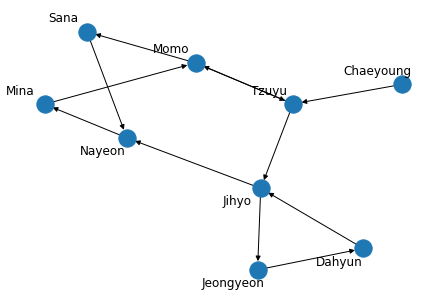

In [73]:
#plot network
pos = nx.kamada_kawai_layout(G)
pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0]-0.1, v[1]+0.1)
    else:
        pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        
labels = {n:n for n in G.nodes()}
nx.draw_kamada_kawai(G)
nx.draw_networkx_labels(G, pos_higher, labels)

{'Nayeon': Text(-0.07194856417850554, -0.6434157326421444, 'Nayeon'),
 'Chaeyoung': Text(0.1063461652341903, 0.33406884024104117, 'Chaeyoung'),
 'Mina': Text(0.5862794216474776, 0.5495734056704583, 'Mina'),
 'Dahyun': Text(-0.391930404875395, 0.8447867187191525, 'Dahyun'),
 'Momo': Text(-1.1, 0.5940628781410756, 'Momo'),
 'Jeongyeon': Text(-0.8274836702918713, -0.6202890991552267, 'Jeongyeon'),
 'Jihyo': Text(-0.5589456775118459, -0.1146690455737807, 'Jihyo'),
 'Tzuyu': Text(0.5707082924295223, -0.784551136715438, 'Tzuyu'),
 'Sana': Text(0.7869744375464282, -0.2595668286851381, 'Sana')}

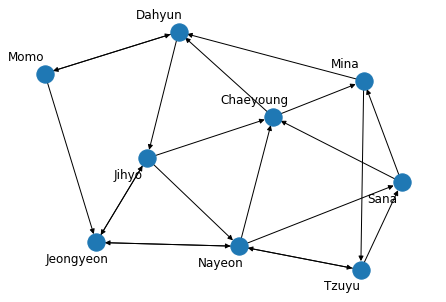

In [39]:
#plot network
pos = nx.kamada_kawai_layout(G)
pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0]-0.1, v[1]+0.1)
    else:
        pos_higher[k] = (v[0]-0.1, v[1]-0.1)
        
labels = {n:n for n in G.nodes()}
nx.draw_kamada_kawai(G)
nx.draw_networkx_labels(G, pos_higher, labels)

In [32]:
from pyvis.network import Network

In [33]:
g = Network(notebook=True,height='500px', width='100%')
g.from_nx(G)
g.show("CryForMe_network_viz.html")